Edge Detection
==============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores local differential operators (grad, div, laplacian) and their use to
perform edge detection.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *
#from nt_solutions import segmentation_1_edge_detection as solutions

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Diffusion and Convolution
-------------------------
To obtain robust edge detection method, it is required to first remove
the noise and small scale features in the image. This can be achieved
using a linear blurring kernel.


Size of the image.

In [2]:
n = 256*2

Load an image $f_0$ of $N=n \times n$ pixels.

In [3]:
f0 = load_image("nt_toolbox/data/hibiscus.bmp",n)

Display it.

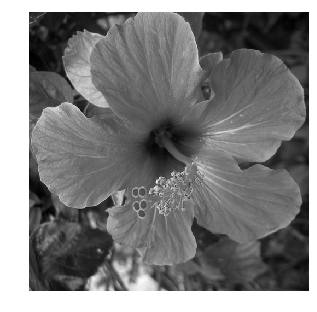

In [4]:
plt.figure(figsize=(5,5))
imageplot(f0)

Blurring is achieved using convolution:
$$ f \star h(x) = \sum_y f(y-x) h(x) $$
where we assume periodic boundary condition.


This can be computed in $O(N\log(N))$ operations using the FFT, since
$$ g = f \star h \qarrq \forall \om, \quad \hat g(\om) = \hat f(\om) \hat h(\om).  $$

In [5]:
cconv = lambda f, h: np.real(pyl.ifft2(pyl.fft2(f)*pyl.fft2(h)))

Define a Gaussian blurring kernel of width $\si$:
$$ h_\si(x) = \frac{1}{Z} e^{ -\frac{x_1^2+x_2^2}{2\si^2} }$$
where $Z$ ensure that $\hat h(0)=1$.

In [6]:
t = np.hstack((np.arange(0,n//2+1),np.arange(-n//2+1,0)))
[X2, X1] = np.meshgrid(t, t)
normalize = lambda h: h/np.sum(h)
h = lambda sigma: normalize(np.exp(-(X1**2 + X2**2)/(2*sigma**2)))

Define blurring operator.

In [7]:
blur = lambda f, sigma: cconv(f, h(sigma))

__Exercise 1__

Test blurring with several blurring size $\si$.

In [8]:
#solutions.exo1()

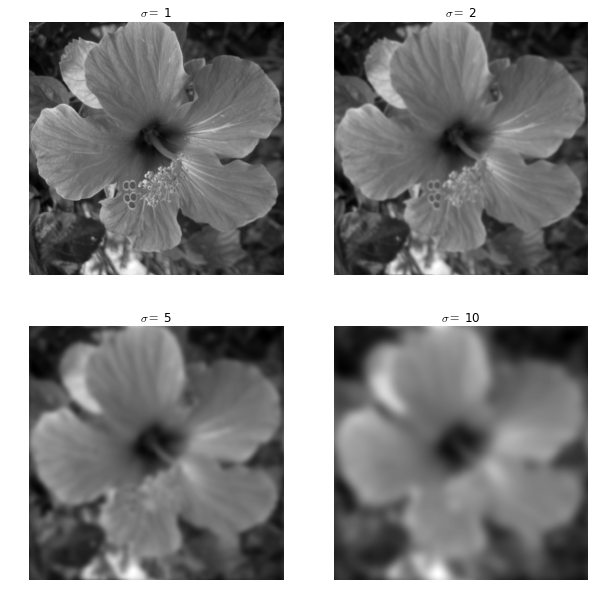

In [9]:
## Insert your code here.

plt.figure(figsize=(10,10))
slist = [1,2,5,10]

for i in range(len(slist)):
    sigma = slist[i]
    imageplot(blur(f0, sigma), "$\sigma = $ %i" %sigma, [2,2,i+1])

Gradient Based Edge Detectiors
------------------------------
The simplest edge detectors only make use of the first order derivatives.


For continuous functions, the gradient reads
$$ \nabla f(x) = \pa{ \pd{f(x)}{x_1}, \pd{f(x)}{x_2} } \in \RR^2. $$


We discretize this differential operator using first order finite
differences.
$$ (\nabla f)_i = ( f_{i_1,i_2}-f_{i_1-1,i_2}, f_{i_1,i_2}-f_{i_1,i_2-1} ) \in \RR^2. $$
Note that for simplity we use periodic boundary conditions.


Compute its gradient, using (here decentered) finite differences.

In [10]:
s = np.hstack(([n-1],np.arange(0,n-1)))
nabla = lambda f: np.stack((f - f[s,:], f - f[:,s]), axis=2)

One thus has $ \nabla : \RR^N \mapsto \RR^{N \times 2}. $

In [11]:
v = nabla(f0)

AttributeError: 'module' object has no attribute 'stack'

One can display each of its components.

In [ ]:
plt.figure(figsize=(10,10))
imageplot(v[:,:,0], "d/dx", [1,2,1])
imageplot(v[:,:,1], "d/dy", [1,2,2])

A simple edge detector is simply obtained by obtained the gradient
magnitude of a smoothed image.



A very simple edge detector is obtained by simply thresholding the
gradient magnitude above some $t>0$. The set $\Ee$ of edges is then
$$ \Ee = \enscond{x}{ d_\si(x) \geq t  } $$
where we have defined
$$ d_\si(x) = \norm{\nabla f_\si(x)}, \qwhereq f_\si = f_0 \star h_\si. $$


Compute $d_\si$ for $\si=1$.

In [ ]:
sigma = 1
d = np.sqrt(np.sum(nabla(blur(f0, sigma))**2, 2))

Display it.

In [ ]:
plt.figure(figsize=(5,5))
imageplot(d)

__Exercise 2__

For $\si=1$, study the influence of the threshold value $t$.

In [ ]:
#solutions.exo2()

In [ ]:
## Insert your code here.

plt.figure(figsize=(10,10))
t_list = np.max(d)*np.array([1./4,1./5,1./10,1./20])

for i in range(len(t_list)):
    t = t_list[i]
    imageplot(d > t, "t = %.1f" %t , [2,2,i+1])

__Exercise 3__

Study the influence of $\si$.

In [ ]:
#solutions.exo3()

In [ ]:
## Insert your code here.

plt.figure(figsize=(10,10))
slist = [1, 2, 4, 6]

for i in range(len(slist)):
    sigma = slist[i]
    d = np.sqrt(np.sum(nabla(blur(f0, sigma))**2, 2))
    t = np.max(d)*1./5
    imageplot(d > t, "$\sigma =$ %.1f" %sigma , [2,2,i+1])

Zero-crossing of the Laplacian
------------------------------
Defining a Laplacian requires to define a divergence operator.
The divergence operator maps vector field to images.
For continuous vector fields $v(x) \in \RR^2$, it is defined as
$$ \text{div}(v)(x) = \pd{v_1(x)}{x_1} +  \pd{v_2(x)}{x_2} \in \RR. $$
It is minus the adjoint of the gadient, i.e. $\text{div} = - \nabla^*$.


It is discretized, for $v=(v^1,v^2)$ as
$$ \text{div}(v)_i = v^1_{i_1+1,i_2} + v^2_{i_1,i_2+1}. $$

In [ ]:
def div(v):
    v0 = v[:,:,0]
    v1 = v[:,:,1]
    t = np.hstack((np.arange(1,n),[0]))
    return v0[t,:] - v0 + v1[:,t] - v1


The Laplacian operatore is defined as $\Delta=\text{div} \circ  \nabla =
-\nabla^* \circ \nabla$. It is thus a negative symmetric operator.

In [ ]:
delta = lambda f: div(nabla(f))

Display $\Delta f_0$.

In [ ]:
plt.figure(figsize=(5,5))
imageplot(delta(f0))

Check that the relation $ \norm{\nabla f} = - \dotp{\Delta f}{f}.  $

In [ ]:
dotp = lambda a, b: np.sum(a*b)
print("Should be 0: %.10f " %(dotp(nabla(f0), nabla(f0)) + dotp(delta(f0), f0)))

The zero crossing of the Laplacian is a well known edge detector.
This requires first blurring the image (which is equivalent to blurring
the laplacian). The set $\Ee$ of edges is defined as:
$$ \Ee = \enscond{x}{ \Delta f_\si(x) = 0  }
      \qwhereq f_\si = f_0 \star h_\si . $$


It was proposed by Marr and Hildreth:


Marr, D. and Hildreth, E.,
_Theory of edge detection,_
In Proc. of the Royal Society London B, 207:187-217, 1980.


Display the zero crossing.

In [ ]:
from nt_toolbox.plot_levelset import *
sigma = 4
    
plt.figure(figsize=(5,5))
plot_levelset(delta(blur(f0, sigma)), 0, f0)

__Exercise 4__

Study the influence of $\si$.

In [ ]:
#solutions.exo4()

In [ ]:
## Insert your code here.

plt.figure(figsize=(10,10))
slist = [4, 6, 10, 15]

for i in range(len(slist)):
    sigma = slist[i]
    plt.subplot(2,2,i+1)
    plot_levelset(delta(blur(f0, sigma)) , 0, f0)
    plt.title("$\sigma = $ %i" %sigma)

Hessian Based Edge Detectors
----------------------------
Zero-crossing of the Laplacian can be shown to
return false edges corresponding to local minima
of the gradient magnitude. Moreover, this operator gives poor localization at curved edges.


In order to improve over this basic detector,
more advanced edge detectors make use of the second order derivatives.
Several authors have advocated for this choice, in particular:


Haralick, R.,
_Digital step edges from zero crossing of second directional derivatives,_
IEEE Trans. on Pattern Analysis and Machine Intelligence, 6(1):58-68, 1984.


Canny, J.,
_A computational approach to edge detection,_
IEEE Trans. on PAMI, 8(6):679-698, 1986


Deriche, R.,
_Using Canny's criteria to derive a recursively implemented optimal edge detector_.
International Journal of Computer Vision, 1:167-187, 1987.


They define the edge locations $\Ee$ as the zero-crossings of the second-order
directional derivative in the gradient direction.
$$ \Ee = \enscond{x}{  \dotp{ H(x) \times g_\si(x) }{ g_\si(x) } = 0 }
      \qwhereq g_\si = \nabla ( f_0 \star h_\si )    $$
where $\times$ is the matrix-vector multiplication.


Define centered first order derivatives.

In [ ]:
dx = lambda f: (f[s,:] - f[t,:])/2
dy = lambda f: np.transpose(dx(np.transpose(f)))

Define second order derivatives.

In [ ]:
s = np.hstack((np.arange(1,n),[0]))
t = np.hstack(([n-1], np.arange(0,n-1)))

d2x = lambda f: f[s,:] + f[t,:] -2*f
d2y = lambda f: np.transpose(d2x(np.transpose(f)))
dxy = lambda f: dy(dx(f))

Define Hessian operator.

In [ ]:
hessian = lambda f: np.stack((d2x(f), dxy(f), d2y(f)), axis=2)

Compute $g_\si = \nabla (f_0 \star h_\si). $

In [ ]:
sigma = 6
g = grad(blur(f0, sigma))

Compute $h_\si = H (f_0 \star h_\si). $

In [ ]:
H = hessian(blur(f0, sigma))

Compute $ a_\si(x) = h_\si(x) \times g_\si (x) $
(this is a matrix times vector operation).

In [ ]:
a = H[:,:,0:2] * np.repeat(g[:,:,0][:,:,np.newaxis],2,axis=2) + H[:,:,1:3] * np.repeat(g[:,:,1][:,:,np.newaxis],2,axis=2)

Display the level set of $\dotp{a_\si(x)}{g_\si(x)}$.

In [ ]:
plt.figure(figsize=(5,5))
plot_levelset(np.sum(a*g, 2), 0, f0)

__Exercise 5__

Study the influence of $\si$.

In [ ]:
#solutions.exo5()

In [ ]:
## Insert your code here.

plt.figure(figsize=(10,10))
slist = [4, 6, 10, 15]

for i in range(len(slist)):
    sigma = slist[i]
     
    g = grad(blur(f0, sigma))
    H = hessian(blur(f0, sigma))
    a = H[:,:,0:2] * np.repeat(g[:,:,0][:,:,np.newaxis],2,axis=2) + H[:,:,1:3] * np.repeat(g[:,:,1][:,:,np.newaxis],2,axis=2)
    
    plt.subplot(2,2,i+1)
    plot_levelset(np.sum(a*g,2), 0, f0)
    plt.title("$\sigma = $ %i" %sigma)